<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/External_Access_to_Amazon_Braket_with_qiskit_braket_provider_mkbahk_20241102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 작업순서
1. Amazon Braket 환경 설정(확인만)
2. S3 환경설정(확인만)
3. (중요) IAM을 이용한 Access Key 설정 및 권한 부여
4. 원격 작업
5. 각종 로그 보기
6. 작업 환경 정리


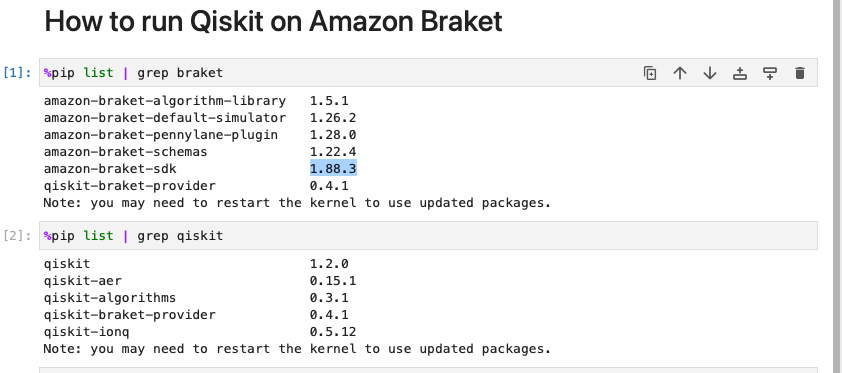

In [1]:
!python3 -m pip install qiskit[visualization]==1.2.0
!python3 -m pip install qiskit-braket-provider==0.4.1
!python3 -m pip install amazon-braket-sdk==1.88.3
#!python3 -m pip install boto3
#!python3 -m pip install botocore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=186d37cceaa81cd2cd65b2b8b02ddac261f1e5e6dcc4ac7e56bec4f2c551a445
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [2]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [3]:
import os
# Set environment variables for AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""
os.environ['AWS_DEFAULT_REGION'] = "us-east-1"

# You can optionally set the s3 bucket and prefix using environment variables
#os.environ['AWS_BRAKET_S3_BUCKET'] = "snuqc"
#os.environ['AWS_BRAKET_S3_PREFIX'] = "amazonbraket"

In [4]:
from qiskit_braket_provider import BraketLocalBackend

local_simulator = BraketLocalBackend()
#local_sv_simulator = BraketLocalBackend(name='braket_sv')
#local_dm_simulator = BraketLocalBackend(name='braket_dm')

In [5]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()
provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
print(provider.backends())

[BraketBackend[Ankaa-2], BraketBackend[Aria 1], BraketBackend[Aria 2], BraketBackend[Forte 1], BraketBackend[Garnet], BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]


In [6]:
#backend = provider.get_backend("Aria 1")
#backend = provider.get_backend("Aria 2")
#backend = provider.get_backend("Forte 1")

#backend= provider.get_backend("Ankaa-2")
#backend = provider.get_backend("Aspen-M-3")

#Ibackend = provider.get_backend("Garnet")

backend = provider.get_backend("SV1")
#backend = provider.get_backend("dm1")
#backend = provider.get_backend("TN1")

In [7]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.measure_all()


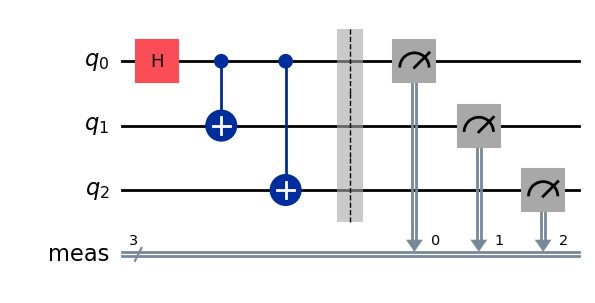

In [8]:
circuit.draw("mpl")

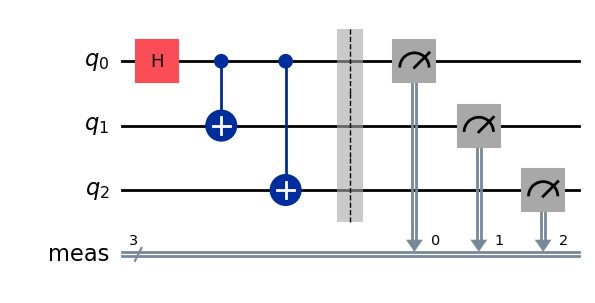

In [9]:
from qiskit.compiler import transpile, assemble
trans_qc = transpile(circuit, backend)
trans_qc.draw("mpl")

In [10]:
from qiskit.providers.jobstatus import JobStatus
import time

job = backend.run(trans_qc, shots=1024)

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 지속적인 실행 상태 확인
#while job.status() is not JobStatus.DONE:
#	print("Job status is", job.status() )
#	time.sleep(2)
###while

/usr/local/lib/python3.10/dist-packages/qiskit_braket_provider/providers/adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(


Job ID is arn:aws:braket:us-east-1:590183937332:quantum-task/5823dd76-9166-4f6f-a3d7-9cca3f51bd9d 



In [11]:
print("Job status is", job.status() )

Job status is JobStatus.DONE


In [ ]:
# 중간에 세션이 종료된 경우 기존에 실행이 완료된 Job을 복구하는 방법
#job = backend.retrieve_job("arn:aws:braket:us-east-1:746669231099:quantum-task/f6fab6be-1590-4da0-914a-fade74efc485")

JobStatus.DONE


In [12]:
result = job.result()
result

Result(backend_name='BraketBackend[SV1]', backend_version='2', qobj_id='0', job_id='arn:aws:braket:us-east-1:590183937332:quantum-task/5823dd76-9166-4f6f-a3d7-9cca3f51bd9d', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'111': 527, '000': 497}, memory=['111', '000', '000', '000', '111', '111', '000', '111', '000', '111', '000', '000', '000', '111', '000', '000', '000', '000', '000', '000', '111', '000', '111', '000', '111', '111', '000', '111', '000', '111', '000', '000', '000', '111', '000', '000', '000', '000', '000', '000', '111', '000', '111', '111', '000', '111', '000', '000', '111', '111', '111', '111', '000', '111', '000', '111', '111', '000', '111', '000', '111', '000', '000', '111', '000', '111', '111', '000', '000', '111', '111', '000', '111', '000', '111', '111', '000', '111', '000', '000', '000', '111', '000', '000', '000', '111', '111', '000', '111', '111', '111', '111', '111', '111', '000', '111', '000', 

In [13]:
# 결과 출력
counts = result.get_counts()
print(counts)

{'111': 527, '000': 497}


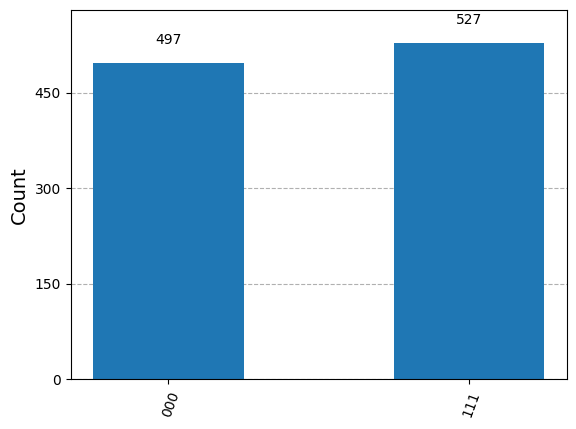

In [14]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)

In [15]:
print("Quantum Task Summary\n")
print(t.quantum_tasks_statistics())
print('\nNote: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. \nEstimated charges shown may differ from your actual charges. \nEstimated charges do not factor in any discounts or credits, \nand you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"\nEstimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary

{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 1024, 'tasks': {'COMPLETED': 1}, 'execution_duration': datetime.timedelta(microseconds=3000), 'billed_execution_duration': datetime.timedelta(seconds=3)}}

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. 
Estimated charges shown may differ from your actual charges. 
Estimated charges do not factor in any discounts or credits, 
and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

Estimated cost to run this example: 0.00 USD
